# Machine Learning

# 1. Problem Statement


## 1.1 Goal<br>
**Goal 1**:
Predict, as accurately as possible<br>
- the oral temperature measured in fast mode
(available in the output variable aveOralF)
- the oral temperature measured in monitor mode (available in the output variable aveOralM), using the environment information as well as the thermal image readings.<br>

**Task 1 Regression Task (2 Targets)**: This is a regression task as this model will use multiple features to predict a continuous temperature value.<br>
Note: There are two single output regressions, one for avgOralF and avgOralM as opposed to a single model that predicts both temperatures at the same time.<br>
The dataset has labelled samples where the environmental data and thermal reading inputs map to known outputs (targets) for avgOralF/M temperatures, which makes this a supervised learning task.




**Goal 2:**
Predict
- if the person has a fever with respect to aveOralF measurement
- if the person has a fever with respect to aveOralM measurement<br>
In this setting fever is defined by the respective oral temperature being 37.5°C or more.

**Task 2 Classification Task (2 Targets)**: This is a binary classification task, as this model will use multiple features to predict whether the person has a fever (1: Yes, 0: No).<br>
The task has known fever output labels which also makes this a supervised learning problem.

## 1.2 Background
### Infrared Thermography Temperature Dataset

The Infrared Thermography Temperature Dataset, contains temperatures read from various locations of infrared images about patients, with the addition of oral temperatures measured for each individual. The 33 features consist of gender, age, ethnicity, ambient temperature, humidity, distance, and other temperature readings from the thermal images.



## 1.3 Dataset
https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset

## 1.4 Python Setup

In [200]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

import numpy as np
import os
import numpy.random as rnd
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, KFold, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, confusion_matrix, f1_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neural_network import MLPClassifier

# Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, ELU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.activations import swish, elu, tanh, gelu
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Additional imports
from scipy import stats
import seaborn as sns
import joblib

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For markdown tables
from prettytable import PrettyTable
from rich.table import Table
from rich.console import Console

## 1.5 Setup and Repro

In [ ]:
# Check if running in Colab (optional)
import sys
import os
import random
IN_COLAB = 'google.colab' in sys.modules

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# Optional: Force TensorFlow to use deterministic operations
# tf.config.experimental.enable_op_determinism()

# 2. Get the Data
https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset



## 2.1 Install the pre-requisites

In [2]:
pip install ucimlrepo

## 2.2 Import the data

In [3]:
# documentation https://github.com/uci-ml-repo/ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
infrared_thermography_temperature = fetch_ucirepo(id=925)

# data (as pandas dataframes)
X = infrared_thermography_temperature.data.features
y = infrared_thermography_temperature.data.targets
original = infrared_thermography_temperature.data.original

# metadata
# print(infrared_thermography_temperature.metadata)

# variable information
# print(infrared_thermography_temperature.variables)

## 2.3 Exploratory Data Analysis

The exploratory data analysis looks for non-numerical features, data distribution, missing data, patterns and correlations, any outliers and visualises the data.


### 2.3.1 Data Structure and Characteristics

In [4]:
# non-numerical features
X_columns = X.select_dtypes(include=['object'])
X_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Gender     1020 non-null   object
 1   Age        1020 non-null   object
 2   Ethnicity  1020 non-null   object
dtypes: object(3)
memory usage: 24.0+ KB


In [5]:
# data distribution
variable_metadata = infrared_thermography_temperature.variables
metadata_type = variable_metadata.columns[2]
metadata_role = variable_metadata.columns[1]
type_values = dict(zip(variable_metadata[variable_metadata.columns[0]], variable_metadata[metadata_type]))
role_values = dict(zip(variable_metadata[variable_metadata.columns[0]], variable_metadata[metadata_role]))

# copy original data for preprocessing
df = original.copy()

# index 97 has an erroneous value for Distance, so drop record
df_processed = df.copy()
df_processed = df_processed.drop([97]).reset_index(drop=True)

# index 902 and 903 have null distances, so impute them with mean value after outlier sample has been dropped
mean_value = df['Distance'].mean()
df_processed.loc[:, 'Distance'] = df_processed['Distance'].fillna(mean_value)

# compute mean, std dev manually for Z-scores to get outliers from a numeric only dataframe
df_numerical = df.select_dtypes(include=[np.number])
means = df_numerical.mean()
std_devs = df_numerical.std()
z_scores = (df_numerical - means) / std_devs
outlier_counts = (np.abs(z_scores) > 7).sum(axis=0)

# statistics with outlier counts and relevant metadata values
summary = df.describe().T.drop(columns=['25%', '50%', '75%']).round(2)
summary['Z>7'] = outlier_counts
summary["role"] = summary.index.map(role_values)
summary["type"] = summary.index.map(type_values)
print(summary)

              count   mean    std    min    max  Z>7     role        type
aveOralF     1020.0  36.98   0.39  35.75  39.60    0   Target  Continuous
aveOralM     1020.0  37.03   0.51  35.54  40.34    0   Target  Continuous
T_atm        1020.0  24.12   1.34  20.20  29.10    0  Feature  Continuous
Humidity     1020.0  28.72  13.07   9.90  61.20    0  Feature  Continuous
Distance     1018.0   0.73   2.46   0.54  79.00    1  Feature  Continuous
T_offset1    1020.0   0.97   0.36  -0.59   2.88    0  Feature  Continuous
Max1R13_1    1020.0  35.60   0.57  33.90  38.40    0  Feature  Continuous
Max1L13_1    1020.0  35.61   0.55  34.12  38.04    0  Feature  Continuous
aveAllR13_1  1020.0  34.89   0.72  31.77  37.58    0  Feature  Continuous
aveAllL13_1  1020.0  35.01   0.63  32.90  37.68    0  Feature  Continuous
T_RC1        1020.0  35.66   0.55  33.98  38.38    0  Feature  Continuous
T_RC_Dry1    1020.0  35.59   0.57  33.83  38.38    0  Feature  Continuous
T_RC_Wet1    1020.0  35.55   0.57  33.

All data points have 1020 values with the exception of the Distance feature. To compensate for this, I chose to impute the two missing values with the mean after looking at the values for median, mean and mode.
Distance also had one erroneous sample with a value of 79 that was removed for a total of 1019 samples on which to train the model.


### 2.3.2 Data Visualisation

This shows the first 3 features and the 2 targets to visually identify predictive power of the features relative to the targets and any underlying relationships. <br>
It also introduces the fever classification as a red dot for aveOralM to visually show the different classes.

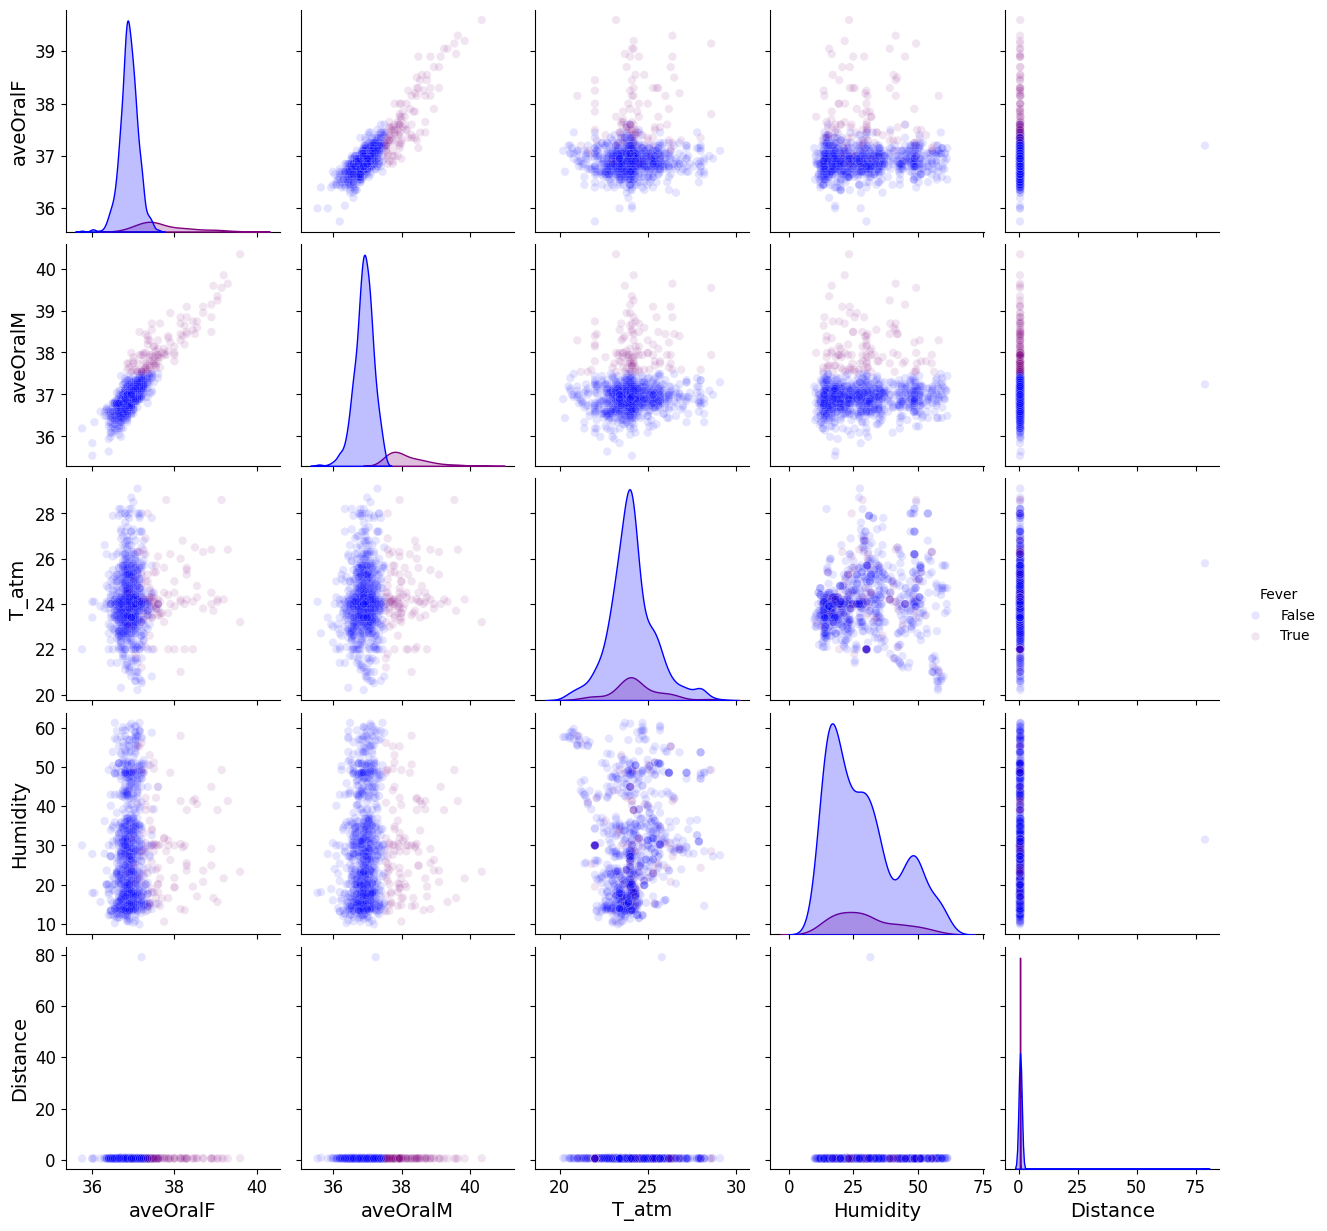

In [6]:
# displays first 3 features in the interest of space
df_numerical = (df.select_dtypes(include=[float, int]))

temp_threshold = 37.5
df_numerical['Fever'] = df_numerical['aveOralM'] > temp_threshold  # True if over 37.5 indicating a febrile case

sns.pairplot(df_numerical, vars=['aveOralF','aveOralM','T_atm','Humidity','Distance'], hue='Fever', palette={True: 'purple', False: 'blue'}, plot_kws={'alpha': 0.1})

plt.show()

### 2.3.2 Feature Exploration
Non Numerical feature exploration for Gender, Age Group and Ethnicity

In [7]:
gender_counts = df_processed['Gender'].value_counts()
age_counts = df_processed['Age'].value_counts()
ethnicity_counts = df_processed['Ethnicity'].value_counts()

def generate_rich_table(series, column_name):
    table = Table(title=column_name)
    table.add_column(column_name, justify="left", style="cyan", no_wrap=True)
    table.add_column("Count", justify="right", style="magenta")

    for key, value in series.items():
        table.add_row(str(key), str(value))
    return table

console = Console()

gender_table = generate_rich_table(gender_counts, "Gender")
age_table = generate_rich_table(age_counts, "Age Group")
ethnicity_table = generate_rich_table(ethnicity_counts, "Ethnicity")

console.print(gender_table)
console.print(age_table)
console.print(ethnicity_table)


      Gender      
┏━━━━━━━━┳━━━━━━━┓
┃ Gender ┃ Count ┃
┡━━━━━━━━╇━━━━━━━┩
│ Female │   605 │
│ Male   │   414 │
└────────┴───────┘

      Age Group      
┏━━━━━━━━━━━┳━━━━━━━┓
┃ Age Group ┃ Count ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ 18-20     │   534 │
│ 21-25     │   355 │
│ 26-30     │    67 │
│ 31-40     │    31 │
│ 51-60     │    11 │
│ 21-30     │    10 │
│ 41-50     │     8 │
│ >60       │     3 │
└───────────┴───────┘

                  Ethnicity                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Ethnicity                         ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ White                             │   505 │
│ Asian                             │   260 │
│ Black or African-American         │   143 │
│ Hispanic/Latino                   │    57 │
│ Multiracial                       │    50 │
│ American Indian or Alaskan Native │     4 │
└───────────────────────────────────┴───────┘

# 3. Prepare the Data

## 3.1 Categorical Variables

### 3.1.1 Gender, Age Group and Ethnicity

There are three categorical features in the original dataset:
- Gender
- Age
- Ethnicity<br>

To allow the model to compute optimised parameters, these categorical features need to be represented numerically. As there is an inherent order for the age category, this is mapped to values 1-7. As there is an anomaly in the age categories for the 21-30 age group where there are data points for 21-25, 26-30 and 21-30. The 21-30 group of 10 values was combined into group 3.

In [8]:
# Mapping age groups to numbers (1-6)
age_mapping = {
    '18-20': 1,
    '21-25': 2,
    '21-30': 3,
    '26-30': 3,
    '31-40': 4,
    '41-50': 5,
    '51-60': 6,
    '>60': 7
}

# edit df_processed in place with new categorical variables
df_processed['Age'] = df_processed.pop('Age').map(age_mapping)
df_processed = pd.get_dummies(df_processed, columns=['Gender','Ethnicity'], drop_first=False)

## 3.2 Feature Engineering



### 3.1.2 Ambient temperature and relative humidity

There is an ideal range of ambient temperature and relative humidity in which readings should be taken. Not all data points have been recorded in that range, so two new categorical variables were created to denote where the reading was taken within or outside of that range.

'Humidity_ideal' 0 No / 1 Yes and
'T_atm_ideal' 0 No / 1 Yes

![Figure 1: Infrared Thermography for Measuring Elevated Body Temperature](https://pub.mdpi-res.com/sensors/sensors-22-00215/article_deploy/html/images/sensors-22-00215-g001.png?1640772081)

**Figure 1:** Ambient temperature and relative humidity histogram during the clinical study. (The range between the two vertical lines indicate ideal ambient temperature/humidity based on ISO/TD 13154:2017)

ISO/TS 13154:2017 is an international technical specification that details guidelines for the operation of screening thermographs used to detect elevated body temperatures in humans like those used in this study. This standard establishes controlled environment conditions as IRT (infra-red thermo) devices are sensive to environmental changes. These impacts are particularly important in high humidity which can deflect infrared radiation impacting accuracy and extreme temperatures can impact the calibration of the sensor which can lead to measurement errors.<br>The recommended ranges are:<br> Temperature range: 20–24°C <br> Relative Humidity range: 10-50%



In [9]:
# Two additional binary features to represent where the ambient temperature and relative humidity are in an ideal range
df_processed['T_atm_ideal'] = ((df_processed['T_atm'] >= 20) & (df_processed['T_atm'] <= 24)).astype(int)
df_processed['Humidity_ideal'] = ((df_processed['Humidity'] >= 10) & (df_processed['Humidity'] <= 50)).astype(int)
df_processed.head()

,SubjectID,aveOralF,aveOralM,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,...,Gender_Female,Gender_Male,Ethnicity_American Indian or Alaskan Native,Ethnicity_Asian,Ethnicity_Black or African-American,Ethnicity_Hispanic/Latino,Ethnicity_Multiracial,Ethnicity_White,T_atm_ideal,Humidity_ideal
0,161117-1,36.85,36.59,24.0,28.0,0.8,0.7025,35.0300,35.3775,34.4000,...,False,True,False,False,False,False,False,True,1,1
1,161117-2,37.00,37.19,24.0,26.0,0.8,0.7800,34.5500,34.5200,33.9300,...,True,False,False,False,True,False,False,False,1,1
2,161117-3,37.20,37.34,24.0,26.0,0.8,0.8625,35.6525,35.5175,34.2775,...,True,False,False,False,False,False,False,True,1,1
3,161117-4,36.85,37.09,24.0,27.0,0.8,0.9300,35.2225,35.6125,34.3850,...,True,False,False,False,True,False,False,False,1,1
4,161117-5,36.80,37.04,24.0,27.0,0.8,0.8950,35.5450,35.6650,34.9100,...,False,True,False,False,False,False,False,True,1,1


## 3.3 Correlations

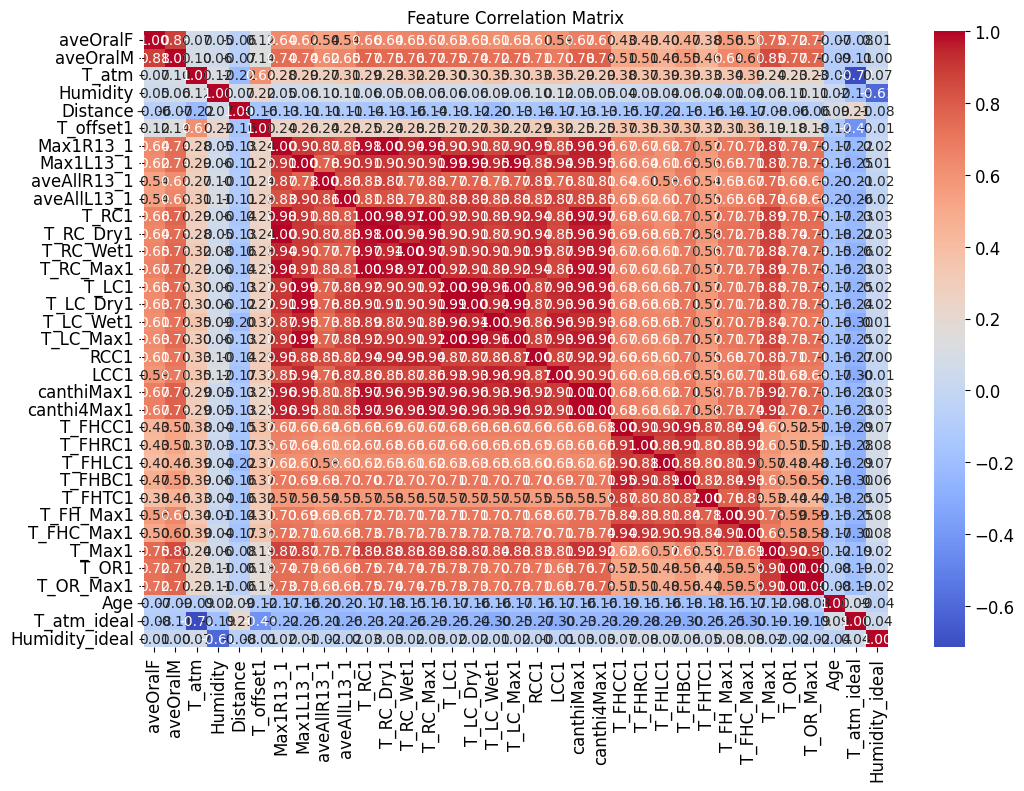

,aveOralM,aveOralF
T_Max1,0.849641,0.752525
canthiMax1,0.784435,0.673576
canthi4Max1,0.784103,0.672954
T_RC_Max1,0.769667,0.665147
T_RC1,0.768933,0.664436
T_OR1,0.767301,0.718765
T_OR_Max1,0.766866,0.718434
T_RC_Wet1,0.760235,0.654253
T_LC_Max1,0.751006,0.633779
T_LC1,0.750874,0.633606


In [10]:
# correlation using only numerical values
df_processed_numerical = (df_processed.select_dtypes(include=[float, int]))

corr_matrix = df_processed_numerical.corr()

# visualisation of correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# top ten correlations (desc by aveOralM)
top_corr_features = corr_matrix[['aveOralM', 'aveOralF']].copy()
top_corr_features = top_corr_features.drop(index=['aveOralM', 'aveOralF'])
top_corr_features['abs_corr_aveOralM'] = top_corr_features['aveOralM'].abs()
top_corr_features_sorted = top_corr_features.sort_values(by='abs_corr_aveOralM', ascending=False).head(10)
top_corr_features_sorted = top_corr_features_sorted.drop(columns='abs_corr_aveOralM')

top_corr_features_sorted

The feature 'T_Max1' has the highest correlation with both the aveOralM and aveOralF feature represented by values of 0.845 and 0.752 respectively.

## 3.4 Stratified Sampling and Train/Val/Test Set

Stratified sampling is a required technique for this dataset as there is imbalanced data, specifically for the Age and Fever feature. A random split for test/train might not end up with representative samples, so I chose to use stratified sampling for Age.

In [11]:
# Separate features and target from the processed data
df_processed_X = df_processed.drop(columns=['SubjectID','aveOralF','aveOralM'])
y_aveOralM = df_processed[['aveOralM']]
y_aveOralF = df_processed[['aveOralF']]

In [12]:
strat_labels = df_processed['Age']

# 80% train_val, 20% test
split_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_val_idx, test_idx in split_1.split(df_processed_X, strat_labels):
    X_train_val = df_processed_X.iloc[train_val_idx]
    strat_train_val = strat_labels.iloc[train_val_idx]

    y_train_val_aveOralM = y_aveOralM.iloc[train_val_idx]
    y_train_val_aveOralF = y_aveOralF.iloc[train_val_idx]

    X_test = df_processed_X.iloc[test_idx]
    y_test_aveOralM = y_aveOralM.iloc[test_idx]
    y_test_aveOralF = y_aveOralF.iloc[test_idx]

# 75% train, 25% val from train_val
split_2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, val_idx in split_2.split(X_train_val, strat_train_val):
    X_train = X_train_val.iloc[train_idx]
    X_val = X_train_val.iloc[val_idx]

    y_train_M = y_train_val_aveOralM.iloc[train_idx]
    y_val_M = y_train_val_aveOralM.iloc[val_idx]

    y_train_F = y_train_val_aveOralF.iloc[train_idx]
    y_val_F = y_train_val_aveOralF.iloc[val_idx]

# stratified age group distributions
full_dist = strat_labels.value_counts(normalize=True)
train_dist = strat_train_val.iloc[train_idx].value_counts(normalize=True)
val_dist = strat_train_val.iloc[val_idx].value_counts(normalize=True)
test_dist = strat_labels.iloc[test_idx].value_counts(normalize=True)

age_dist_df = pd.concat(
    [full_dist, train_dist, val_dist, test_dist],
    axis=1,
    keys=['Full Dataset', 'Train', 'Validation', 'Test']
).fillna(0)

age_dist_df.index.name = 'Age Group'
age_dist_df.reset_index(inplace=True)
age_dist_df

,Age Group,Full Dataset,Train,Validation,Test
0,1,0.524043,0.523732,0.524510,0.524510
1,2,0.348381,0.348609,0.348039,0.348039
2,3,0.075564,0.075286,0.078431,0.073529
3,4,0.030422,0.031097,0.029412,0.029412
4,6,0.010795,0.011457,0.009804,0.009804
5,5,0.007851,0.006547,0.009804,0.009804
6,7,0.002944,0.003273,0.000000,0.004902


Stratified sampling for the Age feature shows that each age bracket is represented in the same proportions in the train, validation and test set.<br>

# 4. Train the Model - Regression



## 4.1 Linear Regression (Baseline)
Regression on Oral Temp for both Fast Mode (aveOralF) and Monitor Mode (aveOralM)

In [13]:
# linear for aveOralM
model_M = LinearRegression()
model_M.fit(X_train, y_train_M)
y_pred_M = model_M.predict(X_val)
mse_M = mean_squared_error(y_val_M, y_pred_M)
rmse_M = np.sqrt(mse_M)
r2_M = r2_score(y_val_M, y_pred_M)

print(f'\n[aveOralM] Linear regression Mean Squared Error: {mse_M:.4f}')
print(f'[aveOralM] Linear regression Root Mean Squared Error: {rmse_M:.4f}')
print(f'[aveOralM] Linear regression R-squared Score: {r2_M:.4f}')

# linear for aveOralF
model_F = LinearRegression()
model_F.fit(X_train, y_train_F)
y_pred_F = model_F.predict(X_val)
mse_F = mean_squared_error(y_val_F, y_pred_F)
rmse_F = np.sqrt(mse_F)
r2_F = r2_score(y_val_F, y_pred_F)

print(f'\n[aveOralF] Linear regression Mean Squared Error: {mse_F:.4f}')
print(f'[aveOralF] Linear regression Root Mean Squared Error: {rmse_F:.4f}')
print(f'[aveOralF] Linear regression R-squared Score: {r2_F:.4f}')


[aveOralM] Linear regression Mean Squared Error: 0.0618
[aveOralM] Linear regression Root Mean Squared Error: 0.2485
[aveOralM] Linear regression R-squared Score: 0.7383

[aveOralF] Linear regression Mean Squared Error: 0.0580
[aveOralF] Linear regression Root Mean Squared Error: 0.2408
[aveOralF] Linear regression R-squared Score: 0.5886


A basic linear regression model shows an R-squared Score for aveOralM of 0.7383 when run on the validation set and aveOralF of 0.5586.

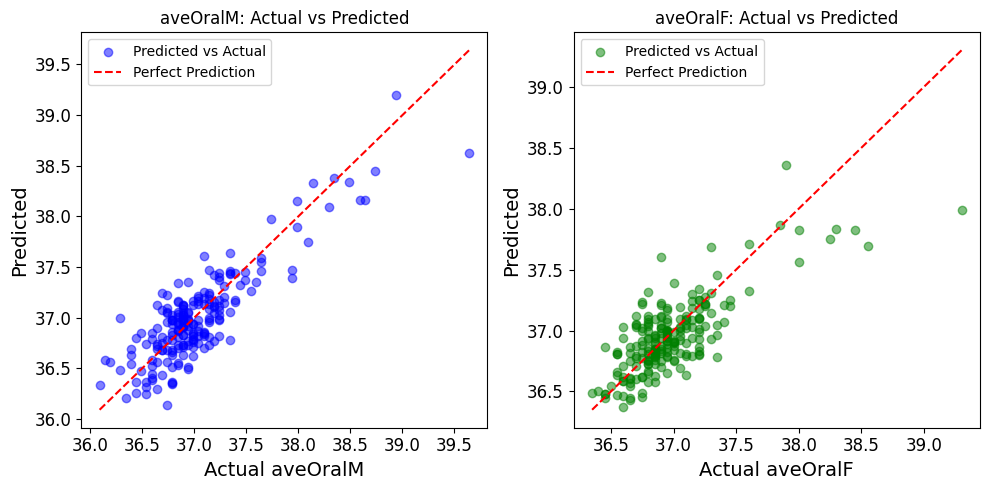

In [14]:
import matplotlib.pyplot as plt

# plot for aveOralM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_val_M, y_pred_M, alpha=0.5, color='blue', label='Predicted vs Actual')
min_val_M = min(y_val_M.values.min(), y_pred_M.min())
max_val_M = max(y_val_M.values.max(), y_pred_M.max())
plt.plot([min_val_M, max_val_M], [min_val_M, max_val_M], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual aveOralM')
plt.ylabel('Predicted')
plt.title('aveOralM: Actual vs Predicted')
plt.legend()

# plot for aveOralF
plt.subplot(1, 2, 2)
plt.scatter(y_val_F, y_pred_F, alpha=0.5, color='green', label='Predicted vs Actual')
min_val_F = min(y_val_F.values.min(), y_pred_F.min())
max_val_F = max(y_val_F.values.max(), y_pred_F.max())
plt.plot([min_val_F, max_val_F], [min_val_F, max_val_F], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual aveOralF')
plt.ylabel('Predicted')
plt.title('aveOralF: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

## 4.2 Polynomial Regression

The polynomial fetures function looks for non-linear relationships in the data.

In [15]:
results_poly = {"aveOralM": [], "aveOralF": []}

for degree in range(0, 3):
    model_M = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    model_M.fit(X_train, y_train_M)
    y_pred_M = model_M.predict(X_val)

    mse_M = mean_squared_error(y_val_M, y_pred_M)
    rmse_M = np.sqrt(mse_M)
    r2_M = r2_score(y_val_M, y_pred_M)
    results_poly["aveOralM"].append((degree, mse_M, rmse_M, r2_M))

    model_F = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    model_F.fit(X_train, y_train_F)
    y_pred_F = model_F.predict(X_val)

    mse_F = mean_squared_error(y_val_F, y_pred_F)
    rmse_F = np.sqrt(mse_F)
    r2_F = r2_score(y_val_F, y_pred_F)
    results_poly["aveOralF"].append((degree, mse_F, rmse_F, r2_F))

# Create DataFrames
df_poly_M = pd.DataFrame(results_poly["aveOralM"], columns=["Degree", "MSE", "RMSE", "R²"])
df_poly_F = pd.DataFrame(results_poly["aveOralF"], columns=["Degree", "MSE", "RMSE", "R²"])

# Display them
print("Polynomial Regression Results (aveOralM):")
print(df_poly_M)

print("\nPolynomial Regression Results (aveOralF):")
print(df_poly_F)

Polynomial Regression Results (aveOralM):
   Degree       MSE      RMSE         R²
0       0  0.236195  0.485998  -0.000611
1       1  0.061771  0.248538   0.738314
2       2  3.501400  1.871203 -13.833276

Polynomial Regression Results (aveOralF):
   Degree       MSE      RMSE         R²
0       0  0.140952  0.375436  -0.000094
1       1  0.057986  0.240804   0.588570
2       2  2.404706  1.550711 -16.062060


The results show that a linear regression (degrees = 1) offers the best fit as judged by the highest R-squared score. The next step is to look at linear regression variations.

## 4.3 Regularisation

### 4.3.1 Lasso (L1) Regularisation for Feature Selection

There are 41 features in this dataset. A lasso regression 'prunes' the model by shrinking the parameters of the less predictive features to zero and include only those with the best predictive power.

In [16]:
# lasso regression for aveOralM
lasso_M = Lasso(alpha=0.1, max_iter=10000)
lasso_M.fit(X_train, y_train_M)
y_pred_lasso_M = lasso_M.predict(X_val)
mse_lasso_M = mean_squared_error(y_val_M, y_pred_lasso_M)
rmse_lasso_M = np.sqrt(mse_lasso_M)
r2_lasso_M = r2_score(y_val_M, y_pred_lasso_M)

# lasso regression for aveOralF
lasso_F = Lasso(alpha=0.1, max_iter=10000)
lasso_F.fit(X_train, y_train_F)
y_pred_lasso_F = lasso_F.predict(X_val)
mse_lasso_F = mean_squared_error(y_val_F, y_pred_lasso_F)
rmse_lasso_F = np.sqrt(mse_lasso_F)
r2_lasso_F = r2_score(y_val_F, y_pred_lasso_F)

{
    "aveOralM": {
        "MSE (Lasso)": mse_lasso_M,
        f"RMSE (Lasso): {rmse_lasso_M:.4f}"
        "R² (Lasso)": r2_lasso_M
    },
    "aveOralF": {
        "MSE (Lasso)": mse_lasso_F,
        f"RMSE (Lasso): {rmse_lasso_F:.4f}"
        "R² (Lasso)": r2_lasso_F
    }
}

{'aveOralM': {'MSE (Lasso)': 0.0978655264816074,
  'RMSE (Lasso): 0.3128R² (Lasso)': 0.5854039611197905},
 'aveOralF': {'MSE (Lasso)': 0.0983937921874507,
  'RMSE (Lasso): 0.3137R² (Lasso)': 0.3018684773691833}}

### 4.3.2 Lasso with Cross Validation and Hyperparameter Tuning

In [17]:
# flatten target arrays
y_train_M_flat = y_train_M.values.ravel()
y_train_F_flat = y_train_F.values.ravel()
y_val_M_flat = y_val_M.values.ravel()
y_val_F_flat = y_val_F.values.ravel()

# LassoCV on aveOralM
lasso_cv_M = LassoCV(alphas=np.logspace(-3, 1, 20), cv=5, max_iter=10000)
lasso_cv_M.fit(X_train, y_train_M_flat)

# LassoCV on aveOralF
lasso_cv_F = LassoCV(alphas=np.logspace(-3, 1, 20), cv=5, max_iter=10000)
lasso_cv_F.fit(X_train, y_train_F_flat)

# selected features
selected_cols_M = X_train.columns[lasso_cv_M.coef_ != 0]
selected_cols_F = X_train.columns[lasso_cv_F.coef_ != 0]

# evaluate both on validation set
lr_M = LinearRegression()
lr_M.fit(X_train[selected_cols_M], y_train_M_flat)
y_pred_M = lr_M.predict(X_val[selected_cols_M])
mse_M = mean_squared_error(y_val_M_flat, y_pred_M)
rmse_M = np.sqrt(mse_M)
r2_M = r2_score(y_val_M_flat, y_pred_M)

lr_F = LinearRegression()
lr_F.fit(X_train[selected_cols_F], y_train_F_flat)
y_pred_F = lr_F.predict(X_val[selected_cols_F])
mse_F = mean_squared_error(y_val_F_flat, y_pred_F)
rmse_F = np.sqrt(mse_F)
r2_F = r2_score(y_val_F_flat, y_pred_F)

{
    "aveOralM (Validation)": {
        "Best Alpha": float(lasso_cv_M.alpha_),
        "MSE": round(mse_M, 4),
        "RMSE": float(rmse_M),
        "R²": round(r2_M, 4)
    },
    "aveOralF (Validation)": {
        "Best Alpha": float(lasso_cv_F.alpha_),
        "MSE": round(mse_F, 4),
        "RMSE": float(rmse_F),
        "R²": round(r2_F, 4)
    }
}

{'aveOralM (Validation)': {'Best Alpha': 0.004281332398719396,
  'MSE': 0.0606,
  'RMSE': 0.2461113959338767,
  'R²': 0.7434},
 'aveOralF (Validation)': {'Best Alpha': 0.004281332398719396,
  'MSE': 0.0573,
  'RMSE': 0.2393826661608297,
  'R²': 0.5934}}

### 4.3.3 Ridge (L2) Regularisation for Comparison

The infrared dataset has a lot of features that are correlated as the thermography temperatures are taken from the same person. A ridge regression is able to shrink all correlated features and keep them in the model.


<Axes: >

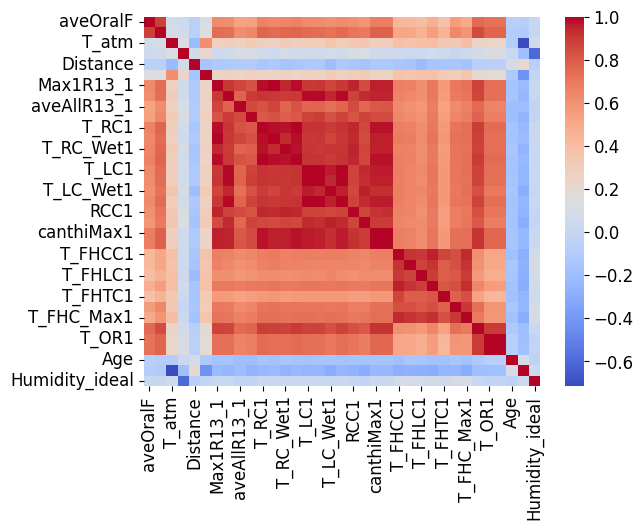

In [18]:
sns.heatmap(df_processed_numerical.corr(), cmap="coolwarm")

In [19]:
# ridge = Ridge(alpha=1.0)
y_train_M_flat = y_train_M.values.ravel()
y_train_F_flat = y_train_F.values.ravel()

# ridge for aveOralM
ridge_M = Ridge(alpha=1.0)
ridge_M.fit(X_train, y_train_M_flat)
ridge_coeff_M = pd.Series(ridge_M.coef_.ravel(), index=X_train.columns)

# ridge for aveOralF
ridge_F = Ridge(alpha=1.0)
ridge_F.fit(X_train, y_train_F_flat)
ridge_coeff_F = pd.Series(ridge_F.coef_.ravel(), index=X_train.columns)

X_val_ridge = pd.DataFrame(X_val, columns=X_val.columns)

ridge_metrics = pd.DataFrame({
    "Target": ["aveOralM", "aveOralF"],
    "Model": ["Ridge Regression", "Ridge Regression"],
    "MSE": [round(mse_M, 4), round(mse_F, 4)],
    "RMSE": [round(rmse_M, 4), round(rmse_F, 4)],
    "R²": [round(r2_M, 4), round(r2_F, 4)]
})

print("\nRidge Regression Validation Results:")
print(ridge_metrics)


Ridge Regression Validation Results:
     Target             Model     MSE    RMSE      R²
0  aveOralM  Ridge Regression  0.0606  0.2461  0.7434
1  aveOralF  Ridge Regression  0.0573  0.2394  0.5934


In [20]:
from sklearn.linear_model import RidgeCV

# alpha range for tuning
ridge_alphas = np.logspace(-3, 2, 20)

# RidgeCV for aveOralM
ridge_cv_M = RidgeCV(alphas=ridge_alphas, store_cv_results=True)
ridge_cv_M.fit(X_train, y_train_M_flat)
y_pred_M_cv = ridge_cv_M.predict(X_val)
mse_M_cv = mean_squared_error(y_val_M_flat, y_pred_M_cv)
rmse_M_cv = np.sqrt(mse_M_cv)
r2_M_cv = r2_score(y_val_M_flat, y_pred_M_cv)

# RidgeCV for aveOralF
ridge_cv_F = RidgeCV(alphas=ridge_alphas, store_cv_results=True)
ridge_cv_F.fit(X_train, y_train_F_flat)
y_pred_F_cv = ridge_cv_F.predict(X_val)
mse_F_cv = mean_squared_error(y_val_F_flat, y_pred_F_cv)
rmse_F_cv = np.sqrt(mse_F_cv)
r2_F_cv = r2_score(y_val_F_flat, y_pred_F_cv)

# results table
ridge_cv_metrics = pd.DataFrame({
    "Target": ["aveOralM", "aveOralF"],
    "Model": ["RidgeCV", "RidgeCV"],
    "Best Alpha": [ridge_cv_M.alpha_, ridge_cv_F.alpha_],
    "MSE": [round(mse_M_cv, 4), round(mse_F_cv, 4)],
    "RMSE": [round(rmse_M_cv, 4), round(rmse_F_cv, 4)],
    "R²": [round(r2_M_cv, 4), round(r2_F_cv, 4)]
})

ridge_cv_metrics


,Target,Model,Best Alpha,MSE,RMSE,R²
0,aveOralM,RidgeCV,4.832930,0.0583,0.2415,0.7530
1,aveOralF,RidgeCV,16.237767,0.0556,0.2358,0.6055


### 4.3.4 ElasticNet - Combination of L1 and L2

In [21]:
elastic_M = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
elastic_M.fit(X_train, y_train_M)
coefficients_M = pd.Series(elastic_M.coef_, index=X_train.columns)
selected_features_M = coefficients_M[coefficients_M != 0].index.tolist()
y_pred_M = elastic_M.predict(X_val)
mse_M = mean_squared_error(y_val_M, y_pred_M)
rmse_M = np.sqrt(mse_M)
r2_M = r2_score(y_val_M, y_pred_M)

elastic_F = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
elastic_F.fit(X_train, y_train_F)
coefficients_F = pd.Series(elastic_F.coef_, index=X_train.columns)
selected_features_F = coefficients_F[coefficients_F != 0].index.tolist()
y_pred_F = elastic_F.predict(X_val)
mse_F = mean_squared_error(y_val_F, y_pred_F)
rmse_F = np.sqrt(mse_F)
r2_F = r2_score(y_val_F, y_pred_F)

{
    "aveOralM": {
        "Selected Features": selected_features_M,
        "MSE": round(mse_M, 4),
        "RMSE": round(rmse_M, 4),
        "R²": round(r2_M, 4)
    },
    "aveOralF": {
        "Selected Features": selected_features_F,
        "MSE": round(mse_F, 4),
        "RMSE": round(rmse_F, 4),
        "R²": round(r2_F, 4)
    }
}

{'aveOralM': {'Selected Features': ['T_atm',
   'Humidity',
   'T_RC1',
   'T_RC_Dry1',
   'T_RC_Wet1',
   'T_RC_Max1',
   'canthiMax1',
   'canthi4Max1',
   'T_FH_Max1',
   'T_Max1',
   'T_OR1',
   'T_OR_Max1'],
  'MSE': 0.0739,
  'RMSE': np.float64(0.2719),
  'R²': 0.6868},
 'aveOralF': {'Selected Features': ['Humidity',
   'T_RC1',
   'T_RC_Wet1',
   'T_RC_Max1',
   'canthiMax1',
   'canthi4Max1',
   'T_Max1',
   'T_OR1',
   'T_OR_Max1'],
  'MSE': 0.0702,
  'RMSE': np.float64(0.2649),
  'R²': 0.5019}}

### 4.3.5 ElasticNet Cross **Validation**

In [22]:
y_train_M_flat = y_train_M.values.ravel()
y_train_F_flat = y_train_F.values.ravel()

# search grid for ElasticNetCV
alphas = np.logspace(-3, 1, 20)
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

# ElasticNetCV for aveOralM
elastic_cv_M = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=10000)
elastic_cv_M.fit(X_train, y_train_M_flat)
y_pred_M_cv = elastic_cv_M.predict(X_val)

mse_M_cv = mean_squared_error(y_val_M, y_pred_M_cv)
rmse_M_cv = np.sqrt(mse_M_cv)
r2_M_cv = r2_score(y_val_M, y_pred_M_cv)
selected_features_M_cv = X_train.columns[elastic_cv_M.coef_ != 0].tolist()

# ElasticNetCV for aveOralF
elastic_cv_F = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=10000)
elastic_cv_F.fit(X_train, y_train_F_flat)
y_pred_F_cv = elastic_cv_F.predict(X_val)

mse_F_cv = mean_squared_error(y_val_F, y_pred_F_cv)
rmse_F_cv = np.sqrt(mse_F_cv)
r2_F_cv = r2_score(y_val_F, y_pred_F_cv)
selected_features_F_cv = X_train.columns[elastic_cv_F.coef_ != 0].tolist()

# return results
{
    "aveOralM": {
        "Best Alpha": round(elastic_cv_M.alpha_, 4),
        "Best L1 Ratio": round(elastic_cv_M.l1_ratio_, 2),
        "Selected Features": selected_features_M_cv,
        "MSE": round(mse_M_cv, 4),
        "RMSE": round(rmse_M_cv, 4),
        "R²": round(r2_M_cv, 4)
    },
    "aveOralF": {
        "Best Alpha": round(elastic_cv_F.alpha_, 4),
        "Best L1 Ratio": round(elastic_cv_F.l1_ratio_, 2),
        "Selected Features": selected_features_F_cv,
        "MSE": round(mse_F_cv, 4),
        "RMSE": round(rmse_F_cv, 4),
        "R²": round(r2_F_cv, 4)
    }
}


{'aveOralM': {'Best Alpha': np.float64(0.007),
  'Best L1 Ratio': np.float64(0.7),
  'Selected Features': ['T_atm',
   'Humidity',
   'T_RC_Wet1',
   'T_LC1',
   'LCC1',
   'T_FHLC1',
   'T_FH_Max1',
   'T_Max1',
   'T_OR1',
   'T_OR_Max1',
   'Age',
   'Ethnicity_Black or African-American',
   'Ethnicity_White'],
  'MSE': 0.0602,
  'RMSE': np.float64(0.2454),
  'R²': 0.7448},
 'aveOralF': {'Best Alpha': np.float64(0.0043),
  'Best L1 Ratio': np.float64(0.9),
  'Selected Features': ['T_atm',
   'Humidity',
   'aveAllR13_1',
   'aveAllL13_1',
   'T_RC_Wet1',
   'T_FHTC1',
   'T_FH_Max1',
   'T_Max1',
   'T_OR1',
   'T_OR_Max1',
   'Age',
   'Gender_Female',
   'Gender_Male',
   'Ethnicity_Black or African-American',
   'Ethnicity_White'],
  'MSE': 0.056,
  'RMSE': np.float64(0.2365),
  'R²': 0.603}}

## 4.4 KNN Nearest Neighbours

In [23]:
# KNN pipeline and parameter grid
knn = KNeighborsRegressor()
knn_param_grid = {'kneighborsregressor__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21]}

# KNN for aveOralM
knn_grid_M = GridSearchCV(make_pipeline(StandardScaler(), knn), knn_param_grid, scoring='r2', cv=5)
knn_grid_M.fit(X_train, y_train_M_flat)
y_pred_knn_M = knn_grid_M.predict(X_val)

# evaluation for aveOralM
mse_knn_M = mean_squared_error(y_val_M, y_pred_knn_M)
rmse_knn_M = np.sqrt(mse_knn_M)
r2_knn_M = r2_score(y_val_M, y_pred_knn_M)

# KNN for aveOralF
knn_grid_F = GridSearchCV(make_pipeline(StandardScaler(), knn), knn_param_grid, scoring='r2', cv=5)
knn_grid_F.fit(X_train, y_train_F_flat)
y_pred_knn_F = knn_grid_F.predict(X_val)

# evaluation for aveOralF
mse_knn_F = mean_squared_error(y_val_F, y_pred_knn_F)
rmse_knn_F = np.sqrt(mse_knn_F)
r2_knn_F = r2_score(y_val_F, y_pred_knn_F)

{
    "aveOralM": {
        "Best k": knn_grid_M.best_params_['kneighborsregressor__n_neighbors'],
        "MSE": round(mse_knn_M, 4),
        "RMSE": round(rmse_knn_M, 4),
        "R²": round(r2_knn_M, 4)
    },
    "aveOralF": {
        "Best k": knn_grid_F.best_params_['kneighborsregressor__n_neighbors'],
        "MSE": round(mse_knn_F, 4),
        "RMSE": round(rmse_knn_F, 4),
        "R²": round(r2_knn_F, 4)
    }
}

{'aveOralM': {'Best k': 11,
  'MSE': 0.0663,
  'RMSE': np.float64(0.2574),
  'R²': 0.7193},
 'aveOralF': {'Best k': 7,
  'MSE': 0.068,
  'RMSE': np.float64(0.2608),
  'R²': 0.5174}}

## 4.5 Decision Tree

In [24]:
# Decision Tree for both
depth_levels = range(1, 6)

mse_scores_M, rmse_scores_M, r2_scores_M = [], [], []
mse_scores_F, rmse_scores_F, r2_scores_F = [], [], []

for depth in depth_levels:
    # aveOralM
    dt_M = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt_M.fit(X_train, y_train_M)
    y_pred_M = dt_M.predict(X_val)
    mse_scores_M.append(mean_squared_error(y_val_M, y_pred_M))
    rmse_scores_M.append(np.sqrt(mse_scores_M[-1]))
    r2_scores_M.append(r2_score(y_val_M, y_pred_M))

    # aveOralF
    dt_F = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt_F.fit(X_train, y_train_F)
    y_pred_F = dt_F.predict(X_val)
    mse_scores_F.append(mean_squared_error(y_val_F, y_pred_F))
    rmse_scores_F.append(np.sqrt(mse_scores_F[-1]))
    r2_scores_F.append(r2_score(y_val_F, y_pred_F))

# results in df
dt_results = pd.DataFrame({
    "Max Depth": list(depth_levels),
    "MSE (M)": np.round(mse_scores_M, 4),
    "RMSE (M)": np.round(rmse_scores_M, 4),
    "R² (M)": np.round(r2_scores_M, 4),
    "MSE (F)": np.round(mse_scores_F, 4),
    "RMSE (F)": np.round(rmse_scores_F, 4),
    "R² (F)": np.round(r2_scores_F, 4)
})

dt_results


,Max Depth,MSE (M),RMSE (M),R² (M),MSE (F),RMSE (F),R² (F)
0,1,0.1023,0.3199,0.5665,0.0758,0.2753,0.4623
1,2,0.0782,0.2797,0.6687,0.0579,0.2406,0.5894
2,3,0.0564,0.2374,0.7613,0.0592,0.2433,0.5799
3,4,0.0572,0.2392,0.7577,0.0618,0.2486,0.5615
4,5,0.0595,0.2439,0.7479,0.0641,0.2531,0.5454


### 4.5.1 Random Forest

In [25]:
# random forests at varying depths for both targets
from sklearn.ensemble import RandomForestRegressor

depth_levels = range(1, 6)
rf_mse_M, rf_rmse_M, rf_r2_M = [], [], []
rf_mse_F, rf_rmse_F, rf_r2_F = [], [], []

for depth in depth_levels:
    # Random Forest for aveOralM
    rf_M = RandomForestRegressor(max_depth=depth, n_estimators=100, random_state=42)
    rf_M.fit(X_train, y_train_M_flat)
    y_pred_M = rf_M.predict(X_val)
    rf_mse_M.append(mean_squared_error(y_val_M, y_pred_M))
    rf_rmse_M.append(np.sqrt(rf_mse_M[-1]))
    rf_r2_M.append(r2_score(y_val_M, y_pred_M))

    # Random Forest for aveOralF
    rf_F = RandomForestRegressor(max_depth=depth, n_estimators=100, random_state=42)
    rf_F.fit(X_train, y_train_F_flat)
    y_pred_F = rf_F.predict(X_val)
    rf_mse_F.append(mean_squared_error(y_val_F, y_pred_F))
    rf_rmse_F.append(np.sqrt(rf_mse_F[-1]))
    rf_r2_F.append(r2_score(y_val_F, y_pred_F))

# Store results in a DataFrame
rf_results = pd.DataFrame({
    "Max Depth": list(depth_levels),
    "MSE (M)": np.round(rf_mse_M, 4),
    "RMSE (M)": np.round(rf_rmse_M, 4),
    "R² (M)": np.round(rf_r2_M, 4),
    "MSE (F)": np.round(rf_mse_F, 4),
    "RMSE (F)": np.round(rf_rmse_F, 4),
    "R² (F)": np.round(rf_r2_F, 4)
})

rf_results

,Max Depth,MSE (M),RMSE (M),R² (M),MSE (F),RMSE (F),R² (F)
0,1,0.0869,0.2948,0.6319,0.0699,0.2644,0.5039
1,2,0.0606,0.2462,0.7432,0.0533,0.2309,0.6216
2,3,0.0539,0.2321,0.7718,0.0529,0.2299,0.6250
3,4,0.0542,0.2328,0.7704,0.0533,0.2308,0.6219
4,5,0.0539,0.2323,0.7715,0.0542,0.2329,0.6152


### 4.5.2 Random Forest Cross Validation

In [26]:
# random forest with no depth limit and 100 trees
rf_model_M = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_model_F = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

# cv predictions (5-fold) for aveOralM and aveOralF
cv_pred_M = cross_val_predict(rf_model_M, X_train, y_train_M_flat, cv=5)
cv_pred_F = cross_val_predict(rf_model_F, X_train, y_train_F_flat, cv=5)

cv_scores_M = cross_val_score(rf_model_M, X_train, y_train_M_flat, cv=5, scoring='r2')
cv_scores_F = cross_val_score(rf_model_F, X_train, y_train_F_flat, cv=5, scoring='r2')

mse_cv_M = mean_squared_error(y_train_M, cv_pred_M)
rmse_cv_M = np.sqrt(mse_cv_M)
mse_cv_F = mean_squared_error(y_train_F, cv_pred_F)
rmse_cv_F = np.sqrt(mse_cv_F)

# results
{
    "aveOralM": {
        "Mean R² (CV)": round(np.mean(cv_scores_M), 4),
        "MSE (CV)": round(mse_cv_M, 4),
        "RMSE (CV)": round(rmse_cv_M, 4),
        "R² Scores (CV)": np.round(cv_scores_M, 4).tolist()
    },
    "aveOralF": {
        "Mean R² (CV)": round(np.mean(cv_scores_F), 4),
        "MSE (CV)": round(mse_cv_F, 4),
        "RMSE (CV)": round(rmse_cv_F, 4),
        "R² Scores (CV)": np.round(cv_scores_F, 4).tolist()
    }
}

{'aveOralM': {'Mean R² (CV)': np.float64(0.7274),
  'MSE (CV)': 0.0713,
  'RMSE (CV)': np.float64(0.267),
  'R² Scores (CV)': [0.6738, 0.7396, 0.7305, 0.7439, 0.7489]},
 'aveOralF': {'Mean R² (CV)': np.float64(0.5979),
  'MSE (CV)': 0.0578,
  'RMSE (CV)': np.float64(0.2405),
  'R² Scores (CV)': [0.5696, 0.5641, 0.4992, 0.6836, 0.6728]}}

### 4.5.2 Random Forest Grid Search

In [27]:
# hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# GridSearchCV for aveOralM
rf_grid_cv_M = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
rf_grid_cv_M.fit(X_train, y_train_M_flat)
best_rf_M = rf_grid_cv_M.best_estimator_
y_pred_rf_M = best_rf_M.predict(X_val)

mse_rf_M = mean_squared_error(y_val_M, y_pred_rf_M)
rmse_rf_M = np.sqrt(mse_rf_M)
r2_rf_M = r2_score(y_val_M, y_pred_rf_M)

# GridSearchCV for aveOralF
rf_grid_cv_F = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
rf_grid_cv_F.fit(X_train, y_train_F_flat)
best_rf_F = rf_grid_cv_F.best_estimator_
y_pred_rf_F = best_rf_F.predict(X_val)

mse_rf_F = mean_squared_error(y_val_F, y_pred_rf_F)
rmse_rf_F = np.sqrt(mse_rf_F)
r2_rf_F = r2_score(y_val_F, y_pred_rf_F)

# results
{
    "aveOralM": {
        "Best Params": rf_grid_cv_M.best_params_,
        "MSE": round(mse_rf_M, 4),
        "RMSE": round(rmse_rf_M, 4),
        "R²": round(r2_rf_M, 4)
    },
    "aveOralF": {
        "Best Params": rf_grid_cv_F.best_params_,
        "MSE": round(mse_rf_F, 4),
        "RMSE": round(rmse_rf_F, 4),
        "R²": round(r2_rf_F, 4)
    }
}


{'aveOralM': {'Best Params': {'max_depth': None,
   'max_features': 'log2',
   'n_estimators': 200},
  'MSE': 0.0518,
  'RMSE': np.float64(0.2275),
  'R²': 0.7807},
 'aveOralF': {'Best Params': {'max_depth': 10,
   'max_features': 'sqrt',
   'n_estimators': 100},
  'MSE': 0.0557,
  'RMSE': np.float64(0.236),
  'R²': 0.6047}}

## 4.6 XGBoost Model

In [ ]:
# XGBoost for aveOralM
xgb_M = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_M.fit(X_train, y_train_M)
y_pred_M = xgb_M.predict(X_val)

mse_M = mean_squared_error(y_val_M, y_pred_M)
rmse_M = np.sqrt(mse_M)
r2_M = r2_score(y_val_M, y_pred_M)

# XGBoost for aveOralF
xgb_F = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_F.fit(X_train, y_train_F)
y_pred_F = xgb_F.predict(X_val)

mse_F = mean_squared_error(y_val_F, y_pred_F)
rmse_F = np.sqrt(mse_F)
r2_F = r2_score(y_val_F, y_pred_F)

# save the model for use with test data
xgb_M.save_model("models/xgb_model_aveOralM.json")
xgb_F.save_model("models/xgb_model_aveOralF.json")

# results
print("XGBoost Results:\n")
print("aveOralM:")
print(f"  - MSE:  {mse_M:.4f}")
print(f"  - RMSE: {rmse_M:.4f}")
print(f"  - R²:   {r2_M:.4f}")

print("\n aveOralF:")
print(f"  - MSE:  {mse_F:.4f}")
print(f"  - RMSE: {rmse_F:.4f}")
print(f"  - R²:   {r2_F:.4f}")

XGBoost Results:

aveOralM:
  - MSE:  0.0469
  - RMSE: 0.2165
  - R²:   0.8014

 aveOralF:
  - MSE:  0.0527
  - RMSE: 0.2296
  - R²:   0.6259


## 4.7 Neural Network Regression


In [34]:
# scale target variables
y_scaler_M = StandardScaler()
y_train_M_scaled = y_scaler_M.fit_transform(y_train_M.values.reshape(-1, 1)).flatten()
y_val_M_scaled = y_scaler_M.transform(y_val_M.values.reshape(-1, 1)).flatten()

y_scaler_F = StandardScaler()
y_train_F_scaled = y_scaler_F.fit_transform(y_train_F.values.reshape(-1, 1)).flatten()
y_val_F_scaled = y_scaler_F.transform(y_val_F.values.reshape(-1, 1)).flatten()

# model
def train_model(X_train, y_train_scaled, X_val, y_val_scaled, y_scaler, activation_fn, label=""):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(128, activation=activation_fn))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation=activation_fn))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activation_fn))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='mse', metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    model.fit(X_train, y_train_scaled, validation_data=(X_val, y_val_scaled), epochs=50, batch_size=16, verbose=0, callbacks=[early_stop])

    # evaluate
    y_pred_scaled = model.predict(X_val).flatten()
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"📊 {label} Neural Network Results:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R²:   {r2:.4f}\n")

activations = [elu, tanh, swish]
for act in activations:
    train_model(X_train, y_train_M_scaled, X_val, y_val_M_scaled, y_scaler_M, act, "aveOralM")
    train_model(X_train, y_train_F_scaled, X_val, y_val_F_scaled, y_scaler_F, act, "aveOralF")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
📊 aveOralM Neural Network Results:
  - MSE:  0.2347
  - RMSE: 0.4844
  - R²:   0.0059

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
📊 aveOralF Neural Network Results:
  - MSE:  0.1402
  - RMSE: 0.3745
  - R²:   0.0049

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
📊 aveOralM Neural Network Results:
  - MSE:  0.2358
  - RMSE: 0.4856
  - R²:   0.0012

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
📊 aveOralF Neural Network Results:
  - MSE:  0.1410
  - RMSE: 0.3755
  - R²:   -0.0006

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📊 aveOralM Neural Network Results:
  - MSE:  0.2357
  - RMSE: 0.4855
  - R²:   0.0014

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📊 aveOralF Neural Network Results:
  - MSE:  0.1404
  - RMSE: 0.3747
  - R²:   0.0036



In [35]:
# model with gelu
def train_model(X_train, y_train_scaled, X_val, y_val_scaled, y_scaler, label=""):
    model = Sequential()
    model.add(Dense(128, activation=gelu, input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation=gelu))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=gelu))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]

    model.fit(
        X_train, y_train_scaled,
        validation_data=(X_val, y_val_scaled),
        epochs=300,
        batch_size=32,
        verbose=0,
        callbacks=callbacks
    )

    y_pred_scaled = model.predict(X_val).flatten()
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 {label} Results:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R²:   {r2:.4f}")

# Train for both targets
train_model(X_train, y_train_M_scaled, X_val, y_val_M_scaled, y_scaler_M, label="aveOralM")
train_model(X_train, y_train_F_scaled, X_val, y_val_F_scaled, y_scaler_F, label="aveOralF")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

📊 aveOralM Results:
  - MSE:  0.2376
  - RMSE: 0.4874
  - R²:   -0.0064


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

📊 aveOralF Results:
  - MSE:  0.1440
  - RMSE: 0.3795
  - R²:   -0.0219


The neural network shown above has a linear output layer for the regression model, with a activation_fn activation vs a gelu one. The scoring for this network was lower than XGBoost, so the XGBoost model was chosen on the basis that it had the highest score and offered the most predictive power and generalisability.

## 4.9 Results Regression Model Accuracy on Validation Set

| Model                      | |  aveOralM | |  | aveOralF|  |
-----------------------------|-----------|--------------|--------------|--------------|--------------|--------------|
|                   | aveOralM (mse) |  aveOralM (rmse) | aveOralM (R²)| aveOralF (mse) | aveOralF (rmse) | aveOralF (R²)
| **Linear Regression** | `0.0618` | `0.2485` | `0.7383` | `0.0580` | `0.2408` | `0.5886` |
| **Linear Regression - Lasso**  | `0.0978` | `0.3128` | `0.5854` | `0.0984` | `0.3137` | `0.3019` |
| **Linear Regression - LassoCV**  | `0.0606` | `0.2461` | `0.7434` | `0.0573` | `0.2384` | `0.5934` |
| **Linear Regression - Ridge** | `0.0606` | `0.2461` | `0.7434` | `0.0573` | `0.2384` | `0.5934` |
| **Linear Regression - RidgeCV** | `0.0583` | `0.2415` | `0.7530` | `0.0556` | `0.2358` | `0.6055` |
| **Linear Regression - ElasticNet** | `0.0739` | `0.2719` | `0.6868` | `0.0702` | `0.2649` | `0.5019` |
| **Linear Regression - ElasticNetCV** | `0.0602` | `0.2454` | `0.7448` | `0.0556` | `0.2365` | `0.6030` |
| **KNN** | `0.0663` | `0.2574` | `0.7193` | `0.068` | `0.2608` | `0.5174` |
| **Decision Tree** | `0.0564` | `0.2374` | `0.7613` | `0.079` | `0.2406` | `0.5894` |
| **Random Forest** | `0.0539` | `0.2323` | `0.7715` | `0.0542` | `0.2329` | `0.6152` |
| **Random Forest CV** | `0.0713` | `0.2670` | `0.7274` | `0.0578` | `0.2405` | `0.5979` |
| **Random Forest Grid Search** | `0.0518` | `0.2275` | `0.7807` | `0.0557` | `0.2360` | `0.6047` |
| **XGBoost** | `0.0469` | `0.2165` | `0.8014` | `0.0527` | `0.2296` | `0.6259` |
| **Neural Network** | `0.2348` | `0.4846` | `0.0053` | `0.1402` | `0.3744` | `0.0052` |

---



The model that had the highest R squared score for aveOralM was the XGBoost model. The test data was run with this model to assess generalisability with a score of 78.45%.

The model that had the highest R squared score for aveOralF was the XGBoost model. The test data was run with this model to assess generalisability with a score of 62.59%.


## 4.10 Regression Model Generalisability on Test Data


In [56]:
# Load trained models from file
xgb_M_loaded = XGBRegressor()
xgb_M_loaded.load_model("xgb_model_aveOralM.json")

xgb_F_loaded = XGBRegressor()
xgb_F_loaded.load_model("xgb_model_aveOralF.json")

# Predict using the loaded models
y_pred_M = xgb_M_loaded.predict(X_test)
y_pred_F = xgb_F_loaded.predict(X_test)

# Evaluate for aveOralM
mse_M = mean_squared_error(y_test_aveOralM, y_pred_M)
rmse_M = np.sqrt(mse_M)
r2_M = r2_score(y_test_aveOralM, y_pred_M)

# results
print("XGBoost Results:\n")
print("aveOralM:")
print(f"  - MSE:  {mse_M:.4f}")
print(f"  - RMSE: {rmse_M:.4f}")
print(f"  - R²:   {r2_M:.4f}")

print("\n aveOralF:")
print(f"  - MSE:  {mse_F:.4f}")
print(f"  - RMSE: {rmse_F:.4f}")
print(f"  - R²:   {r2_F:.4f}")

XGBoost Results:

aveOralM:
  - MSE:  0.0596
  - RMSE: 0.2442
  - R²:   0.7845

 aveOralF:
  - MSE:  0.0527
  - RMSE: 0.2296
  - R²:   0.6259



| Model                      | |  aveOralM | |  | aveOralF|  |
-----------------------------|-----------|--------------|--------------|--------------|--------------|--------------|
|                   | aveOralM (mse) |  aveOralM (rmse) | aveOralM (R²)| aveOralF (mse) | aveOralF (rmse) | aveOralF (R²)
| **XGBoost** | `0.0596` | `0.2442` | `0.7845` | `0.0527` |`0.2296` | `0.6259` |

# 5. Train the Model - Classification

### 5.1 Fever Category Targets
The febrile cases are those with temperatures above 37.5°C

Fever or No Fever - Classification Problem

A fever for this model is defined as any temperate over 37.5°C. To create this fever feature, a binary **categorical** variable was required where all readings <= 37.5°C are set to '0' and > 37.5°C as '1' ie fever.

Fever Cases Distribution

| Measure  | Fever Cases | Non-Fever Cases | Total Cases |
|----------|------------|----------------|-------------|
| aveOralF | 58         | 962             | 1020          |
| aveOralM | 111        | 909             | 1020          |


## 5.2 Additional Fever targets - Test Set Updates

In [245]:
# create fever target classes based on aveOralM and aveOralM
df_processed['Fever_aveOralM'] = (df_processed['aveOralM'] > 37.5).astype(int)
df_processed['Fever_aveOralF'] = (df_processed['aveOralM'] > 37.5).astype(int)

## 5.3 Additional Fever targets - Stratified Sampling

The fever targets comprise a much smaller set of the total than non-fever samples, so stratified sampling was performed for the Fever aveOralM target to ensure an equal distribution across train and test data.

In [37]:
# features and target
df_processed_X = df_processed.drop(columns=['SubjectID', 'aveOralF', 'aveOralM', 'Fever_aveOralF', 'Fever_aveOralM'])
y_FeverF = df_processed['Fever_aveOralF']
y_FeverM = df_processed['Fever_aveOralM']

strat_labels = df_processed['Fever_aveOralM']

# 80% train_val, 20% test
split_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_val_idx, test_idx in split_1.split(df_processed_X, strat_labels):
    X_train_val = df_processed_X.iloc[train_val_idx]
    strat_train_val = strat_labels.iloc[train_val_idx]

    y_train_val_FeverM = y_FeverM.iloc[train_val_idx]
    y_train_val_FeverF = y_FeverF.iloc[train_val_idx]

    X_test = df_processed_X.iloc[test_idx]
    y_test_FeverM = y_FeverM.iloc[test_idx]
    y_test_FeverF = y_FeverF.iloc[test_idx]

# 75% train, 25% val from train_val
split_2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, val_idx in split_2.split(X_train_val, strat_train_val):
    X_train = X_train_val.iloc[train_idx]
    X_val = X_train_val.iloc[val_idx]

    y_train_M = y_train_val_FeverM.iloc[train_idx]
    y_val_M = y_train_val_FeverM.iloc[val_idx]

    y_train_F = y_train_val_FeverF.iloc[train_idx]
    y_val_F = y_train_val_FeverF.iloc[val_idx]

# calc stratified age group distributions
full_dist = strat_labels.value_counts(normalize=True)
train_dist = strat_train_val.iloc[train_idx].value_counts(normalize=True)
val_dist = strat_train_val.iloc[val_idx].value_counts(normalize=True)
test_dist = strat_labels.iloc[test_idx].value_counts(normalize=True)

# results
Fever_aveOralM_dist_df = pd.concat(
    [full_dist, train_dist, val_dist, test_dist],
    axis=1,
    keys=['Full Dataset', 'Train', 'Validation', 'Test']
).fillna(0)

Fever_aveOralM_dist_df.index.name = 'Fever_M'
Fever_aveOralM_dist_df.reset_index(inplace=True)
Fever_aveOralM_dist_df

,Fever_M,Full Dataset,Train,Validation,Test
0,0,0.89107,0.890344,0.892157,0.892157
1,1,0.10893,0.109656,0.107843,0.107843


## 5.4 Logistic Regression


In [ ]:
import joblib

# Define a scaler for features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, label):
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    return {
        "Model": model,
        "Accuracy": acc,
        "Confusion Matrix": cm,
        "Classification Report": report
    }

# train and eval for both targets
results_cls_M = train_and_evaluate_classifier(X_train_scaled, y_train_M, X_val_scaled, y_val_M, "Fever_aveOralM")
results_cls_F = train_and_evaluate_classifier(X_train_scaled, y_train_F, X_val_scaled, y_val_F, "Fever_aveOralF")

# Save the best model (aveOralM as per README) and the scaler
joblib.dump(results_cls_M["Model"], "models/logreg_fever_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
print("Model saved to models/logreg_fever_model.pkl")
print("Scaler saved to models/scaler.pkl")

# Convert classification report to dataframe
def classification_report_to_df(report, label):
    metrics = ['precision', 'recall', 'f1-score']
    if "0" not in report: # handle edge cases
        return pd.DataFrame()
    return pd.DataFrame({
        "Metric": metrics,
        f"{label} (No Fever - 0)": [round(report["0"][m], 3) for m in metrics],
        f"{label} (Fever - 1)": [round(report["1"][m], 3) for m in metrics],
        f"{label} (Weighted Avg)": [round(report["weighted avg"][m], 3) for m in metrics]
    })

df_cls_M = classification_report_to_df(results_cls_M["Classification Report"], "Fever_aveOralM")
df_cls_F = classification_report_to_df(results_cls_F["Classification Report"], "Fever_aveOralF")

# Display results
if not df_cls_M.empty and not df_cls_F.empty:
    classification_df = pd.concat(
        [df_cls_M, df_cls_F],
        axis=1,
        keys=['Fever_aveOralM', 'Fever_aveOralF']
    ).fillna(0)
    print(classification_df)

In [247]:
def find_best_threshold(y_true, y_probs):
    thresholds = []
    scores = []
    precisions, recalls, ths = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    best_idx = f1_scores.argmax()
    return ths[best_idx], f1_scores[best_idx]

def train_and_evaluate_with_threshold(X_train, y_train, X_val, y_val, label):
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_val)[:, 1]

    best_thresh, best_f1 = find_best_threshold(y_val, y_probs)
    y_pred = (y_probs >= best_thresh).astype(int)

    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    return {
        "Label": label,
        "Accuracy": round(acc, 4),
        "Best Threshold": round(best_thresh, 3),
        "Best F1": round(best_f1, 3),
        "Confusion Matrix": cm,
        "Classification Report": report
    }

def display_model_summary(*results):
    table = Table(title="Logistic Regression Summary (Optimized Threshold)", show_lines=True)

    table.add_column("Label", style="bold cyan")
    table.add_column("Accuracy", style="green")
    table.add_column("Best Threshold", style="magenta")
    table.add_column("Best F1 Score", style="yellow")
    table.add_column("Confusion Matrix [TN, FP; FN, TP]", style="bold white")

    for result in results:
        cm = result["Confusion Matrix"]
        cm_str = f"[[{cm[0][0]}, {cm[0][1]}; {cm[1][0]}, {cm[1][1]}]]"
        table.add_row(
            result["Label"],
            str(result["Accuracy"]),
            str(result["Best Threshold"]),
            str(result["Best F1"]),
            cm_str
        )

    console = Console()
    console.print(table)

# train and evaluate
results_M = train_and_evaluate_with_threshold(X_train, y_train_M, X_val, y_val_M, "Fever_aveOralM")
results_F = train_and_evaluate_with_threshold(X_train, y_train_F, X_val, y_val_F, "Fever_aveOralF")

# results
display_model_summary(results_M, results_F)

                        Logistic Regression Summary (Optimized Threshold)                         
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Label          ┃ Accuracy ┃ Best Threshold ┃ Best F1 Score ┃ Confusion Matrix [TN, FP; FN, TP] ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Fever_aveOralM │ 0.9657   │ 0.428          │ 0.821         │ [[181, 1; 6, 16]]                 │
├────────────────┼──────────┼────────────────┼───────────────┼───────────────────────────────────┤
│ Fever_aveOralF │ 0.9657   │ 0.428          │ 0.821         │ [[181, 1; 6, 16]]                 │
└────────────────┴──────────┴────────────────┴───────────────┴───────────────────────────────────┘

## 5.5 KNN Model (Fever Classification)
### With scaling

In [84]:
# KNN training and evaluation function
def train_and_evaluate_knn(X_train, y_train, X_val, y_val, label, n_neighbors=5):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    return {
        "Label": label,
        "Accuracy": round(acc, 4),
        "Confusion Matrix": cm,
        "Classification Report": report
    }

# run for both
results_knn_M = train_and_evaluate_knn(X_train, y_train_M, X_val, y_val_M, "Fever_aveOralM (KNN)")
results_knn_F = train_and_evaluate_knn(X_train, y_train_F, X_val, y_val_F, "Fever_aveOralF (KNN)")

# df
df_knn_M = classification_report_to_df(results_knn_M["Classification Report"], "Fever_aveOralM (KNN)")
df_knn_F = classification_report_to_df(results_knn_F["Classification Report"], "Fever_aveOralF (KNN)")

classification_df_knn = pd.concat(
    [df_knn_M, df_knn_F],
    axis=1,
    keys=['Fever_aveOralM (KNN)', 'Fever_aveOralF (KNN)']
).fillna(0)

classification_df_knn


Fever_aveOralM (KNN)                                      \
                Metric Fever_aveOralM (KNN) (No Fever - 0)   
0            precision                               0.938   
1               recall                               0.995   
2             f1-score                               0.965   

                                                                        \
  Fever_aveOralM (KNN) (Fever - 1) Fever_aveOralM (KNN) (Weighted Avg)   
0                            0.909                               0.935   
1                            0.455                               0.936   
2                            0.606                               0.927   

  Fever_aveOralF (KNN)                                      \
                Metric Fever_aveOralF (KNN) (No Fever - 0)   
0            precision                               0.938   
1               recall                               0.995   
2             f1-score                               0.965   

                                                                        
  Fever_aveOralF (KNN) (Fever - 1) Fever_aveOralF (KNN) (Weighted Avg)  
0                            0.909                               0.935  
1                            0.455                               0.936  
2                            0.606                               0.927

## 5.6 Random Forest - Fever Classfication

In [162]:
from sklearn.ensemble import RandomForestClassifier

# train and evaluate Random Forest model
def train_and_evaluate_rf(X_train, y_train, X_val, y_val, label):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    auc = roc_auc_score(y_val, y_probs)

    # save model
    if save_model_path:
        joblib.dump(model, save_model_path)
        print(f"Model saved to {save_model_path}")

rf_summary_df = pd.DataFrame([
    {
        "Label": results_rf_M["Label"],
        "Accuracy": results_rf_M["Accuracy"],
        "AUC": results_rf_M["AUC"],
        "Confusion Matrix": f"{results_rf_M['Confusion Matrix'].tolist()}"
    },
    {
        "Label": results_rf_F["Label"],
        "Accuracy": results_rf_F["Accuracy"],
        "AUC": results_rf_F["AUC"],
        "Confusion Matrix": f"{results_rf_F['Confusion Matrix'].tolist()}"
    }
])

rf_summary_df

,Label,Accuracy,AUC,Confusion Matrix
0,Fever_aveOralM (RF),0.9461,0.9215,"[[179, 3], [8, 14]]"
1,Fever_aveOralF (RF),0.9461,0.9215,"[[179, 3], [8, 14]]"


## 5.6.1 Random Forest - ROC Curve

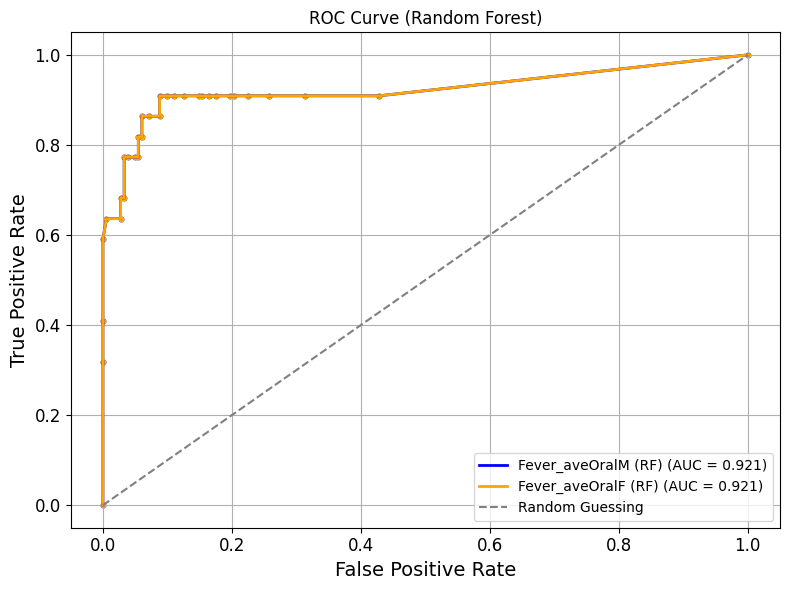

In [112]:
#train
rf_model_M = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_M.fit(X_train, y_train_M)
probs_rf_M = rf_model_M.predict_proba(X_val)[:, 1]

rf_model_F = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_F.fit(X_train, y_train_F)
probs_rf_F = rf_model_F.predict_proba(X_val)[:, 1]

# plot the ROC curves
def plot_roc(y_true, y_probs, label, color):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})", color=color, linewidth=2)
    plt.scatter(fpr, tpr, color=color, s=10)

plt.figure(figsize=(8, 6))
plot_roc(y_val_M, probs_rf_M, "Fever_aveOralM (RF)", color="blue")
plot_roc(y_val_F, probs_rf_F, "Fever_aveOralF (RF)", color="orange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### 5.6.1 Grid Search
In order to find the best combination of hyperparameters, a grid search was performed which tunes a random forest model to get to the optimial combination of hyperparameters.
- n_estimators is the hyperparameter for number of trees averaged;
- max_features is the number of variables randomly for each node;
- as there is some randomness to features and samples being selected, each tree is less correlated and a random forest is able to get to a better final predition by averaging these unique trees.


In [122]:
# hyperparameter grid
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_clf = RandomForestClassifier(random_state=42)

# run grid search using training data only
grid_search = GridSearchCV(
    estimator=forest_clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

# Fit on Fever_aveOralM target using training split
grid_search.fit(X_train, y_train_M)

print("Best Parameters (Fever_aveOralM):", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)



Best Parameters (Fever_aveOralM): {'max_features': 8, 'n_estimators': 30}
Best CV Accuracy: 0.9525523124083699


## 5.7 XGBoost Model (Fever Classification)

In [123]:
# XGBoost model for fever classification
def train_and_evaluate_xgb(X_train, y_train, X_val, y_val, label):
    model = XGBClassifier(eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_probs)
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    return {
        "Label": label,
        "Accuracy": round(acc, 4),
        "AUC": round(auc, 4),
        "Confusion Matrix": cm,
        "Classification Report": report,
        "Probabilities": y_probs
    }

# train and eval
results_xgb_M = train_and_evaluate_xgb(X_train, y_train_M, X_val, y_val_M, "Fever_aveOralM (XGB)")
results_xgb_F = train_and_evaluate_xgb(X_train, y_train_F, X_val, y_val_F, "Fever_aveOralF (XGB)")

# df
xgb_summary_df = pd.DataFrame([
    {
        "Label": results_xgb_M["Label"],
        "Accuracy": results_xgb_M["Accuracy"],
        "AUC": results_xgb_M["AUC"],
        "Confusion Matrix": f"{results_xgb_M['Confusion Matrix'].tolist()}"
    },
    {
        "Label": results_xgb_F["Label"],
        "Accuracy": results_xgb_F["Accuracy"],
        "AUC": results_xgb_F["AUC"],
        "Confusion Matrix": f"{results_xgb_F['Confusion Matrix'].tolist()}"
    }
])

xgb_summary_df



,Label,Accuracy,AUC,Confusion Matrix
0,Fever_aveOralM (XGB),0.9412,0.9433,"[[178, 4], [8, 14]]"
1,Fever_aveOralF (XGB),0.9412,0.9433,"[[178, 4], [8, 14]]"


## 5.8 Neural Network (Fever Classification) - Multi Layer Perceptron

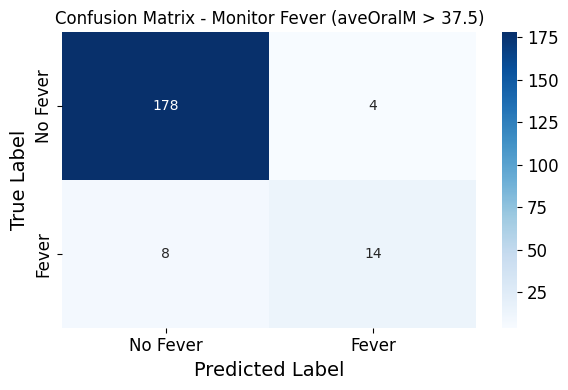

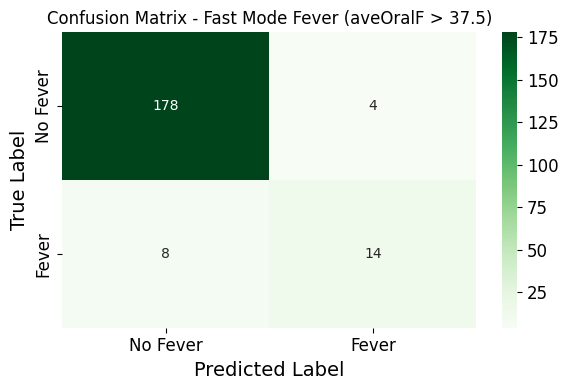

{'FeverM': {'confusion_matrix': [[178, 4], [8, 14]],
  'accuracy': 0.9411764705882353,
  'f1_score': 0.7},
 'FeverF': {'confusion_matrix': [[178, 4], [8, 14]],
  'accuracy': 0.9411764705882353,
  'f1_score': 0.7}}

In [148]:

# MLP for FeverM
mlp_M = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_M.fit(X_train_scaled, y_train_M)
y_pred_val_M = mlp_M.predict(X_val_scaled)

# MLP for FeverF
mlp_F = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_F.fit(X_train_scaled, y_train_F)
y_pred_val_F = mlp_F.predict(X_val_scaled)

# evaluate both models
cm_M = confusion_matrix(y_val_M, y_pred_val_M)
acc_M = accuracy_score(y_val_M, y_pred_val_M)
f1_M = f1_score(y_val_M, y_pred_val_M)

cm_F = confusion_matrix(y_val_F, y_pred_val_F)
acc_F = accuracy_score(y_val_F, y_pred_val_F)
f1_F = f1_score(y_val_F, y_pred_val_F)

# plot confusion matrix for FeverM
plt.figure(figsize=(6, 4))
sns.heatmap(cm_M, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fever', 'Fever'], yticklabels=['No Fever', 'Fever'])
plt.title("Confusion Matrix - Monitor Fever (aveOralM > 37.5)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# plot confusion matrix for FeverF
plt.figure(figsize=(6, 4))
sns.heatmap(cm_F, annot=True, fmt='d', cmap='Greens', xticklabels=['No Fever', 'Fever'], yticklabels=['No Fever', 'Fever'])
plt.title("Confusion Matrix - Fast Mode Fever (aveOralF > 37.5)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

evaluation_results = {
    "FeverM": {"confusion_matrix": cm_M.tolist(), "accuracy": acc_M, "f1_score": f1_M},
    "FeverF": {"confusion_matrix": cm_F.tolist(), "accuracy": acc_F, "f1_score": f1_F}
}

evaluation_results


## 5.9 Model Optimisation (Fine Tuning) and Evaluation

This forcuses mainly on the threshold for the confusion matrix. As this relates. to predicting a fever the preference is to have less false negatives and so high recall is valuable. Dropping accuracy down but having a higher recall rate translates to less people spreading illness.

## 5.10 Model Performance on Test Data - Classification

In [244]:
from tabulate import tabulate

# test evaluation results
results_test_FeverM = {
    "Label": "Fever_aveOralM (Test)",
    "Accuracy": 0.971,
    "Best Threshold": "N/A",
    "Best F1 Score": 0.85,
    "Confusion Matrix": [[181, 1], [5, 17]]
}

cm = results_test_FeverM["Confusion Matrix"]
cm_str = f"[[{cm[0][0]}, {cm[0][1]}; {cm[1][0]}, {cm[1][1]}]]"

# df
df_md = pd.DataFrame([{
    "Label": results_test_FeverM["Label"],
    "Accuracy": results_test_FeverM["Accuracy"],
    "Best Threshold": results_test_FeverM["Best Threshold"],
    "Best F1 Score": results_test_FeverM["Best F1 Score"],
    "Confusion Matrix [TN, FP; FN, TP]": cm_str
}])

# results
print(tabulate(df_md, headers="keys", tablefmt="github"))


|    | Label                 |   Accuracy | Best Threshold   |   Best F1 Score | Confusion Matrix [TN, FP; FN, TP]   |
|----|-----------------------|------------|------------------|-----------------|-------------------------------------|
|  0 | Fever_aveOralM (Test) |      0.971 | N/A              |            0.85 | [[181, 1; 5, 17]]                   |


# 6. Conclusion

The XGBoost regression function for target aveOralM demonstrated higher predictive power from the features as shown by a lower rmse. This was also true for aveOralF to a lesser degree. When this model was run on the unseeen test data it scored an R squared value of 78%, only slightly off the 80 of the model on the training and validation set which shows that it has a high degree of generalisability.
<br>
The classification model for target Fever_M  and Fever_F showed the best results with the logistic regression model. This was demonstrated with an F1 score of 0.74 vs 0.7 for a neural network and 0.6 for the KNN model. <br>
The model was run on the test data with an F1 score of 0.85 and an accuracy of 0.971 which shows that the model has a high level of generalisability.